In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import pyximport
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from collections import defaultdict
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, pearsonr, skew
from sklearn.preprocessing import MinMaxScaler

In [271]:
data_df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])

high = set(pd.read_csv("data/lfm/high_main_users.txt")["user_id"])
med = set(pd.read_csv("data/lfm/medium_main_users.txt")["user_id"])
low = set(pd.read_csv("data/lfm/low_main_users.txt")["user_id"])

#high = set(np.random.choice(list(high), size=100, replace=False))
#med = set(np.random.choice(list(med), size=100, replace=False))
#low = set(np.random.choice(list(low), size=100, replace=False))

data_df = data_df[data_df["user_id"].isin(high.union(med).union(low))]

In [275]:
data_df.groupby("item_id").size().max() / data_df.groupby("item_id").size().mean()

279.1711477012421

In [210]:
avg_profile_size_high = data_df[data_df["user_id"].isin(high)].groupby("user_id").size().mean()
avg_profile_size_med = data_df[data_df["user_id"].isin(med)].groupby("user_id").size().mean()
avg_profile_size_low = data_df[data_df["user_id"].isin(low)].groupby("user_id").size().mean()
print("Avg. profile size of high-mainstream users: %f" % avg_profile_size_high)
print("Avg. profile size of medium-mainstream users: %f" % avg_profile_size_med)
print("Avg. profile size of low-mainstream users: %f" % avg_profile_size_low)

Avg. profile size of high-mainstream users: 539.800000
Avg. profile size of medium-mainstream users: 715.669000
Avg. profile size of low-mainstream users: 499.892000


In [211]:
item_popularity = data_df.groupby("item_id").size() / data_df["user_id"].nunique()
top_popular_items = set(item_popularity.sort_values(ascending=False).head(int(len(item_popularity) * 0.2)).index.tolist())

fracpop = defaultdict(list)
for uid, group in data_df.groupby("user_id")["item_id"]:
    n_rated_popular = len(set(group.values).intersection(top_popular_items))
    frac_popular = n_rated_popular / len(group)
    if uid in high:
        fracpop["high"].append(frac_popular)
    elif uid in med:
        fracpop["med"].append(frac_popular)
    else:
        fracpop["low"].append(frac_popular)

In [212]:
np.mean(fracpop["high"]), np.mean(fracpop["med"]), np.mean(fracpop["low"])

(0.8392176168323453, 0.8353800943325365, 0.8069202105529865)

In [222]:
np.median(fracpop["high"]), np.median(fracpop["med"]), np.median(fracpop["low"])

(0.8662462238612735, 0.8639867659222498, 0.8372529615507758)

0.09299276384585588 -1.446362208539379
0.09319506400356117 -1.3737628863612434
0.12890074339861646 -1.10103430957968


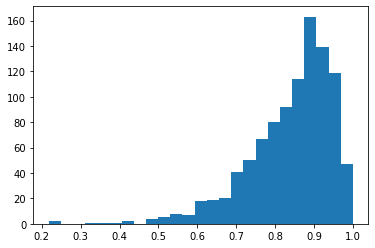

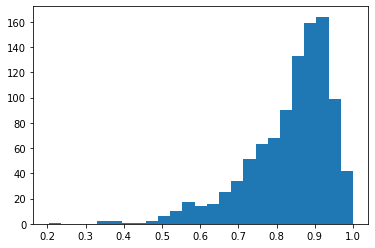

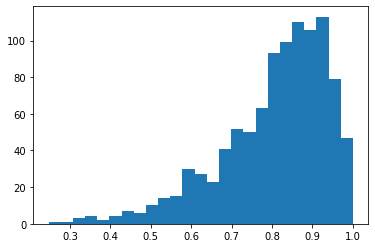

In [221]:
def gini(x):
    x = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad / np.mean(x)
    g = 0.5 * rmad
    return g

plt.figure()
plt.hist(fracpop["high"], bins=25);
print(gini(fracpop["high"]), skew(fracpop["high"]))

plt.figure()
plt.hist(fracpop["med"], bins=25);
print(gini(fracpop["med"]), skew(fracpop["med"]))

plt.figure()
plt.hist(fracpop["low"], bins=25);
print(gini(fracpop["low"]), skew(fracpop["low"]))

1389.0000000000002


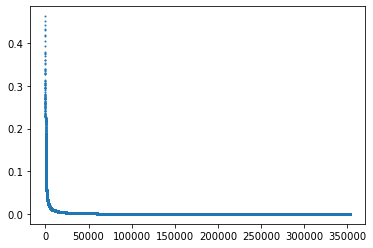

In [267]:
ip = df.groupby("item_id").size() / df["user_id"].nunique()
plt.figure
plt.scatter(list(range(len(item_popularity))), item_popularity.sort_values(ascending=False), s=1)
print(max(item_popularity) / np.median(item_popularity))

407.33333333333337
915.0


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


27.757085020242915


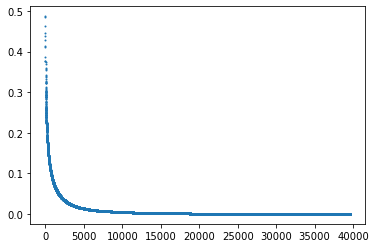

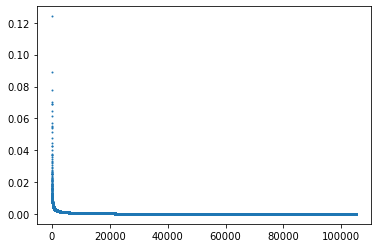

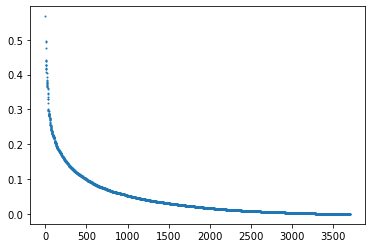

In [270]:
df = pd.read_csv("data/douban/douban.csv", sep=";", names=["user_id", "item_id", "rating"])
ip = df.groupby("item_id").size() / df["user_id"].nunique()
plt.figure()
plt.scatter(list(range(len(ip))), ip.sort_values(ascending=False), s=1)
print(max(ip) / np.median(ip))

df = pd.read_csv("data/ciao/ciao.csv", sep=";", names=["user_id", "item_id", "rating"])
ip = df.groupby("item_id").size() / df["user_id"].nunique()
plt.figure()
plt.scatter(list(range(len(ip))), ip.sort_values(ascending=False), s=1)
print(max(ip) / np.median(ip))

df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
ip = df.groupby("item_id").size() / df["user_id"].nunique()
plt.figure()
plt.scatter(list(range(len(ip))), ip.sort_values(ascending=False), s=1)
print(max(ip) / np.median(ip))

In [199]:
dataset = Dataset.load_from_df(data_df, reader=Reader(rating_scale=(1, 1000)))
trainset, testset = train_test_split(dataset, test_size=0.2)

sim = UserKNN.compute_similarities(trainset, min_support=1)
pop = UserKNN.compute_popularities(trainset)
gain = UserKNN.compute_gain(trainset)

In [41]:
def find_query_destinations(m, high, med, low):
    n_queries_high, n_queries_med,n_queries_low = [], [], []
    for iuid, n_queries in enumerate(m.n_queries):
        ruid = m.trainset.to_raw_uid(iuid)
        if ruid in high:
            n_queries_high.append(n_queries)
        elif ruid in med:
            n_queries_med.append(n_queries)
        elif ruid in low:
            n_queries_low.append(n_queries)
        else:
            print("User id %d not found!" % ruid)
            
    sum_queries_high = np.sum(n_queries_high)
    sum_queries_med = np.sum(n_queries_med)
    sum_queries_low = np.sum(n_queries_low)
    sum_queries_all = sum_queries_high + sum_queries_med + sum_queries_low
    
    return sum_queries_high / sum_queries_all, sum_queries_med / sum_queries_all, sum_queries_low / sum_queries_all

In [42]:
frac_to_high = defaultdict(list)
frac_to_med = defaultdict(list)
frac_to_low = defaultdict(list)

Ks = [5, 10, 15, 20, 25, 30]
for k_idx, k in enumerate(Ks):
    print()
    print("------ k=%d ------" % k)
    # UserKNN
    m = UserKNN(k=k, precomputed_sim=sim, reuse=False)
    m.fit(trainset)
    _ = m.test(testset)
    frac_to_high_k, frac_to_med_k, frac_to_low_k = find_query_destinations(m, high, med, low)
    frac_to_high["UserKNN"].append(frac_to_high_k)
    frac_to_med["UserKNN"].append(frac_to_med_k)
    frac_to_low["UserKNN"].append(frac_to_low_k)
    print("[UserKNN] High: %.4f, Medium: %.4f, Low: %.4f" % (frac_to_high_k, frac_to_med_k, frac_to_low_k))
    
    # UserKNN+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, reuse=True)
    m.fit(trainset)
    _ = m.test(testset)
    frac_to_high_k, frac_to_med_k, frac_to_low_k = find_query_destinations(m, high, med, low)
    frac_to_high["UserKNN+Reuse"].append(frac_to_high_k)
    frac_to_med["UserKNN+Reuse"].append(frac_to_med_k)
    frac_to_low["UserKNN+Reuse"].append(frac_to_low_k)
    print("[UserKNN+Reuse] High: %.4f, Medium: %.4f, Low: %.4f" % (frac_to_high_k, frac_to_med_k, frac_to_low_k))
    
    # Popularity
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop, reuse=False, tau_2=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    frac_to_high_k, frac_to_med_k, frac_to_low_k = find_query_destinations(m, high, med, low)
    frac_to_high["Popularity"].append(frac_to_high_k)
    frac_to_med["Popularity"].append(frac_to_med_k)
    frac_to_low["Popularity"].append(frac_to_low_k)
    print("[Popularity] High: %.4f, Medium: %.4f, Low: %.4f" % (frac_to_high_k, frac_to_med_k, frac_to_low_k))
    
    # Popularity+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop, reuse=True, tau_2=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    frac_to_high_k, frac_to_med_k, frac_to_low_k = find_query_destinations(m, high, med, low)
    frac_to_high["Popularity+Reuse"].append(frac_to_high_k)
    frac_to_med["Popularity+Reuse"].append(frac_to_med_k)
    frac_to_low["Popularity+Reuse"].append(frac_to_low_k)
    print("[Popularity+Reuse] High: %.4f, Medium: %.4f, Low: %.4f" % (frac_to_high_k, frac_to_med_k, frac_to_low_k))
    
    # Gain
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, reuse=False, tau_4=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    frac_to_high_k, frac_to_med_k, frac_to_low_k = find_query_destinations(m, high, med, low)
    frac_to_high["Gain"].append(frac_to_high_k)
    frac_to_med["Gain"].append(frac_to_med_k)
    frac_to_low["Gain"].append(frac_to_low_k)
    print("[Gain] High: %.4f, Medium: %.4f, Low: %.4f" % (frac_to_high_k, frac_to_med_k, frac_to_low_k))
    
    # Gain+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, reuse=True, tau_4=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    frac_to_high_k, frac_to_med_k, frac_to_low_k = find_query_destinations(m, high, med, low)
    frac_to_high["Gain+Reuse"].append(frac_to_high_k)
    frac_to_med["Gain+Reuse"].append(frac_to_med_k)
    frac_to_low["Gain+Reuse"].append(frac_to_low_k)
    print("[Gain+Reuse] High: %.4f, Medium: %.4f, Low: %.4f" % (frac_to_high_k, frac_to_med_k, frac_to_low_k))


------ k=5 ------
[UserKNN] High: 0.3475, Medium: 0.3568, Low: 0.2957
[UserKNN+Reuse] High: 0.3636, Medium: 0.3897, Low: 0.2466
[Popularity] High: 0.4404, Medium: 0.4153, Low: 0.1443
[Popularity+Reuse] High: 0.3973, Medium: 0.4169, Low: 0.1858
[Gain] High: 0.4330, Medium: 0.4043, Low: 0.1627
[Gain+Reuse] High: 0.3982, Medium: 0.4096, Low: 0.1922

------ k=10 ------
[UserKNN] High: 0.3612, Medium: 0.3667, Low: 0.2721
[UserKNN+Reuse] High: 0.3739, Medium: 0.3955, Low: 0.2306
[Popularity] High: 0.4319, Medium: 0.4166, Low: 0.1516
[Popularity+Reuse] High: 0.3969, Medium: 0.4156, Low: 0.1876
[Gain] High: 0.4288, Medium: 0.4063, Low: 0.1650
[Gain+Reuse] High: 0.3981, Medium: 0.4100, Low: 0.1919

------ k=15 ------
[UserKNN] High: 0.3691, Medium: 0.3715, Low: 0.2594
[UserKNN+Reuse] High: 0.3795, Medium: 0.3967, Low: 0.2238
[Popularity] High: 0.4274, Medium: 0.4169, Low: 0.1557
[Popularity+Reuse] High: 0.3975, Medium: 0.4138, Low: 0.1887
[Gain] High: 0.4259, Medium: 0.4067, Low: 0.1674
[Gain+

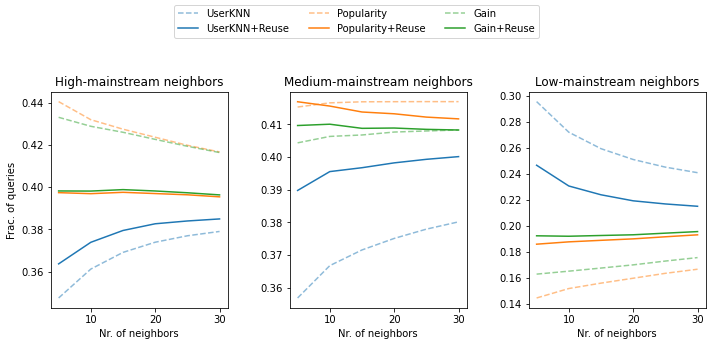

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].plot(Ks, frac_to_high["UserKNN"], color="C0", linestyle="dashed", alpha=0.5)
axes[0].plot(Ks, frac_to_high["Popularity"], color="C1", linestyle="dashed", alpha=0.5)
axes[0].plot(Ks, frac_to_high["Gain"], color="C2", linestyle="dashed", alpha=0.5)
axes[0].plot(Ks, frac_to_high["UserKNN+Reuse"], color="C0", linestyle="solid")
axes[0].plot(Ks, frac_to_high["Popularity+Reuse"], color="C1", linestyle="solid")
axes[0].plot(Ks, frac_to_high["Gain+Reuse"], color="C2", linestyle="solid")

axes[1].plot(Ks, frac_to_med["UserKNN"], color="C0", linestyle="dashed", alpha=0.5)
axes[1].plot(Ks, frac_to_med["Popularity"], color="C1", linestyle="dashed", alpha=0.5)
axes[1].plot(Ks, frac_to_med["Gain"], color="C2", linestyle="dashed", alpha=0.5)
axes[1].plot(Ks, frac_to_med["UserKNN+Reuse"], color="C0", linestyle="solid")
axes[1].plot(Ks, frac_to_med["Popularity+Reuse"], color="C1", linestyle="solid")
axes[1].plot(Ks, frac_to_med["Gain+Reuse"], color="C2", linestyle="solid")

axes[2].plot(Ks, frac_to_low["UserKNN"], color="C0", linestyle="dashed", alpha=0.5)
axes[2].plot(Ks, frac_to_low["Popularity"], color="C1", linestyle="dashed", alpha=0.5)
axes[2].plot(Ks, frac_to_low["Gain"], color="C2", linestyle="dashed", alpha=0.5)
axes[2].plot(Ks, frac_to_low["UserKNN+Reuse"], color="C0", linestyle="solid")
axes[2].plot(Ks, frac_to_low["Popularity+Reuse"], color="C1", linestyle="solid")
axes[2].plot(Ks, frac_to_low["Gain+Reuse"], color="C2", linestyle="solid")

axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")

axes[0].set_ylabel("Frac. of queries")

axes[0].set_title("High-mainstream neighbors")
axes[1].set_title("Medium-mainstream neighbors")
axes[2].set_title("Low-mainstream neighbors")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

In [81]:
item_popularity = data_df.groupby("item_id").size() / data_df["user_id"].nunique()
top_popular_items = set(item_popularity.sort_values(ascending=False).head(int(len(item_popularity) * 0.2)).index.tolist())

fracpop = dict()
for uid, group in data_df.groupby("user_id")["item_id"]:
    n_rated_popular = len(set(group.values).intersection(top_popular_items))
    frac_popular = n_rated_popular / len(group)#len(top_popular_items)
    fracpop[uid] = frac_popular

def get_avg_fracpop(m, fracpop_per_user):
    avg_fracpop = 0
    for iuid, n_queries in enumerate(m.n_queries):
        ruid = m.trainset.to_raw_uid(iuid)
        avg_fracpop += fracpop[ruid] * n_queries
    avg_fracpop /= np.sum(m.n_queries)
    
    return avg_fracpop
    
    
avg_fracpop = defaultdict(list)
Ks = [5, 10, 15, 20, 25, 30]
for k_idx, k in enumerate(Ks):
    print()
    print("------ k=%d ------" % k)
    # UserKNN
    m = UserKNN(k=k, precomputed_sim=sim, reuse=False)
    m.fit(trainset)
    _ = m.test(testset)
    avg_fracpop_k = get_avg_fracpop(m, fracpop)
    avg_fracpop["UserKNN"].append(avg_fracpop_k)
    print("[UserKNN] Avg. fraction of popular items: %f" % avg_fracpop_k)
    
    # UserKNN+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, reuse=True)
    m.fit(trainset)
    _ = m.test(testset)
    avg_fracpop_k = get_avg_fracpop(m, fracpop)
    avg_fracpop["UserKNN+Reuse"].append(avg_fracpop_k)
    print("[UserKNN+Reuse] Avg. fraction of popular items: %f" % avg_fracpop_k)
    
    # Popularity
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop, reuse=False, tau_2=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    avg_fracpop_k = get_avg_fracpop(m, fracpop)
    avg_fracpop["Popularity"].append(avg_fracpop_k)
    print("[Popularity] Avg. fraction of popular items: %f" % avg_fracpop_k)
    
    # Popularity+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop, reuse=True, tau_2=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    avg_fracpop_k = get_avg_fracpop(m, fracpop)
    avg_fracpop["Popularity+Reuse"].append(avg_fracpop_k)
    print("[Popularity+Reuse] Avg. fraction of popular items: %f" % avg_fracpop_k)
    
    # Gain
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, reuse=False, tau_4=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    avg_fracpop_k = get_avg_fracpop(m, fracpop)
    avg_fracpop["Gain"].append(avg_fracpop_k)
    print("[Gain] Avg. fraction of popular items: %f" % avg_fracpop_k)
    
    # Gain+Reuse
    m = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, reuse=True, tau_4=0.5)
    m.fit(trainset)
    _ = m.test(testset)
    avg_fracpop_k = get_avg_fracpop(m, fracpop)
    avg_fracpop["Gain+Reuse"].append(avg_fracpop_k)
    print("[Gain+Reuse] Avg. fraction of popular items: %f" % avg_fracpop_k)


------ k=5 ------
[UserKNN] Avg. fraction of popular items: 0.828289
[UserKNN+Reuse] Avg. fraction of popular items: 0.834424
[Popularity] Avg. fraction of popular items: 0.853028
[Popularity+Reuse] Avg. fraction of popular items: 0.844858
[Gain] Avg. fraction of popular items: 0.851099
[Gain+Reuse] Avg. fraction of popular items: 0.844070

------ k=10 ------
[UserKNN] Avg. fraction of popular items: 0.835499
[UserKNN+Reuse] Avg. fraction of popular items: 0.841034
[Popularity] Avg. fraction of popular items: 0.854491
[Popularity+Reuse] Avg. fraction of popular items: 0.847832
[Gain] Avg. fraction of popular items: 0.853099
[Gain+Reuse] Avg. fraction of popular items: 0.847580

------ k=15 ------
[UserKNN] Avg. fraction of popular items: 0.839491
[UserKNN+Reuse] Avg. fraction of popular items: 0.844320
[Popularity] Avg. fraction of popular items: 0.855244
[Popularity+Reuse] Avg. fraction of popular items: 0.849463
[Gain] Avg. fraction of popular items: 0.854094
[Gain+Reuse] Avg. fract

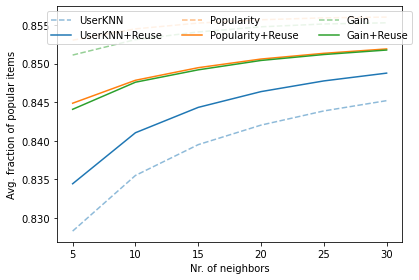

In [82]:
plt.plot(Ks, avg_fracpop["UserKNN"], color="C0", linestyle="dashed", alpha=0.5)
plt.plot(Ks, avg_fracpop["Popularity"], color="C1", linestyle="dashed", alpha=0.5)
plt.plot(Ks, avg_fracpop["Gain"], color="C2", linestyle="dashed", alpha=0.5)
plt.plot(Ks, avg_fracpop["UserKNN+Reuse"], color="C0", linestyle="solid")
plt.plot(Ks, avg_fracpop["Popularity+Reuse"], color="C1", linestyle="solid")
plt.plot(Ks, avg_fracpop["Gain+Reuse"], color="C2", linestyle="solid")

plt.ylabel("Avg. fraction of popular items")
plt.xlabel("Nr. of neighbors")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]
plt.legend(lines, labels, ncol=3, loc='upper center')
plt.tight_layout()

In [123]:
data_df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])

high = set(pd.read_csv("data/lfm/high_main_users.txt")["user_id"])
med = set(pd.read_csv("data/lfm/medium_main_users.txt")["user_id"])
low = set(pd.read_csv("data/lfm/low_main_users.txt")["user_id"])

high = set(np.random.choice(list(high), size=100, replace=False))
med = set(np.random.choice(list(med), size=100, replace=False))
low = set(np.random.choice(list(low), size=100, replace=False))

data_df = data_df[data_df["user_id"].isin(high.union(med).union(low))]

In [125]:
item_popularity_all = np.zeros(data_df["item_id"].nunique())
item_popularity_high = np.zeros(data_df["item_id"].nunique())
item_popularity_med = np.zeros(data_df["item_id"].nunique())
item_popularity_low = np.zeros(data_df["item_id"].nunique())

iid_map = {b: a for a, b in enumerate(data_df["item_id"].unique())}

print("all")
for iid, count in data_df.groupby("item_id").size().items():
    pop = count / data_df["user_id"].nunique()
    item_popularity_all[iid_map[iid]] = pop
print("high")
for iid, count in data_df[data_df["user_id"].isin(high)].groupby("item_id").size().items():
    pop = count / len(high)
    item_popularity_high[iid_map[iid]] = pop
print("med")
for iid, count in data_df[data_df["user_id"].isin(med)].groupby("item_id").size().items():
    pop = count / len(med)
    item_popularity_med[iid_map[iid]] = pop
print("low")
for iid, count in data_df[data_df["user_id"].isin(low)].groupby("item_id").size().items():
    pop = count / len(low)
    item_popularity_low[iid_map[iid]] = pop

all
high
med
low


In [126]:
print(spearmanr(item_popularity_all, item_popularity_high))
print(spearmanr(item_popularity_all, item_popularity_med))
print(spearmanr(item_popularity_all, item_popularity_low))

SpearmanrResult(correlation=0.4902825039419818, pvalue=0.0)
SpearmanrResult(correlation=0.5307863573969765, pvalue=0.0)
SpearmanrResult(correlation=0.43870249336278844, pvalue=0.0)


In [129]:
print(pearsonr(item_popularity_all, item_popularity_high))
print(pearsonr(item_popularity_all, item_popularity_med))
print(pearsonr(item_popularity_all, item_popularity_low))

(0.9489505015102964, 0.0)
(0.9518162711999794, 0.0)
(0.8638512085643901, 0.0)
